# Estimate the known vs novel credbile sets

### Download the dataset of known vs novel studies

In [ ]:
!gcloud storage cp -r gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/known_studyLocusIds ../../data/.
!mkdir -p ../../data/counts


Copying gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/known_studyLocusIds/_SUCCESS to file://../../data/known_studyLocusIds/_SUCCESS
Copying gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/known_studyLocusIds/part-00000-2f0f4342-2a7e-4b1e-b6e0-8883049cb9a4-c000.snappy.parquet to file://../../data/known_studyLocusIds/part-00000-2f0f4342-2a7e-4b1e-b6e0-8883049cb9a4-c000.snappy.parquet
Copying gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/known_studyLocusIds/part-00001-2f0f4342-2a7e-4b1e-b6e0-8883049cb9a4-c000.snappy.parquet to file://../../data/known_studyLocusIds/part-00001-2f0f4342-2a7e-4b1e-b6e0-8883049cb9a4-c000.snappy.parquet
Copying gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/known_studyLocusIds/part-00002-2f0f4342-2a7e-4b1e-b6e0-8883049cb9a4-c000.snappy.parquet to file://../../data/known_studyLocusIds/part-00002-2f0f4342-2a7e-4b1e-b6e0-8883049cb9a4-c000.snappy.parquet
Copying gs://genetics-portal-dev-a

In [ ]:
import polars as pl
import seaborn as sns
from gentropy.common.session import Session
from matplotlib import pyplot as plt
from pyspark.sql import DataFrame
from pyspark.sql import functions as f


In [8]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
variant_index_path = "../../data/variant"
study_index_path = "../../data/study"
credible_set_path = "../../data/credible_set"
known_studies_path = "../../data/known_studyLocusIds"


In [9]:
ks = session.spark.read.parquet(known_studies_path)
cs = session.spark.read.parquet(credible_set_path)


In [10]:
def classify_study_locus(all: DataFrame, known: DataFrame) -> DataFrame:
    """Classify study locus ids based on known or novel."""
    assert "studyLocusId" in all.columns and "studyLocusId" in known.columns
    known = known.withColumn("studyLocusClass", f.lit("known")).alias("r")
    classified = all.alias("l").join(known, on="studyLocusId", how="left")
    return classified.withColumn(
        "studyLocusClass", f.when(f.col("studyLocusClass") == "known", f.lit("known")).otherwise("novel")
    )


### GWAS credible sets - novel vs known

In [16]:
classified_cs = classify_study_locus(cs, ks).filter(f.col("studyType") == "gwas")
grouped = (
    classified_cs.groupBy("studyLocusClass")
    .agg(f.count("studyLocusId").alias("count"))
    .select(
        f.col("studyLocusClass"),
        f.col("count"),
        f.round((f.col("count") / f.lit(classified_cs.count()) * f.lit(100)), 2).alias("%"),
    )
)

grouped.coalesce(1).toPandas().to_csv("../../data/counts/known_vs_novel.csv", index=False)
grouped.show()


+---------------+------+-----+
|studyLocusClass| count|    %|
+---------------+------+-----+
|          novel|272902|47.26|
|          known|304569|52.74|
+---------------+------+-----+



In [ ]:
dataset = pl.read_csv("../../data/counts/known_vs_novel.csv")


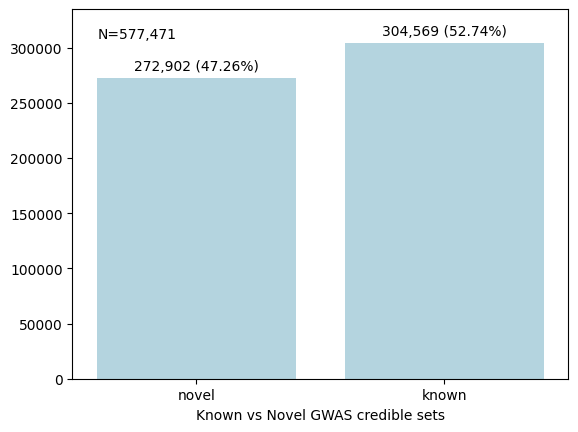

In [15]:
data = dataset
ax = sns.barplot(data=data, x="studyLocusClass", y="count", color="lightblue")
N = data["count"].sum()
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f"{round(x):,} ({round(x / N * 100, 2)}%)", padding=3)
ax.set_ylim(0, data["count"].max() * 1.1)
ax.set_ylabel("")
ax.set_xlabel("Known vs Novel GWAS credible sets")
ax.text(
    x=0.05,
    y=0.95,
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
    s=f"N={N:,}",
)
plt.show()
